In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

# Task 1 - Densce coding
Coding 2 cbits with 1 qbit

Task realised with 4qbit circuit, where q0 and q1 corresponds to classical bits to be coded

In [2]:
def coding_circuit(classical_state):
    c = QuantumCircuit(4, 4)
    # Move classical state to circuit
    if(classical_state[0] == 1):
        c.x(0)
    if(classical_state[1] == 1):
        c.x(1)
    c.barrier()
    c.h(2)
    c.cx(2, 3)
    c.barrier()
    c.cx(1, 2)
    c.cz(0, 2)
    c.barrier()
    c.cx(2, 3)
    c.h(2)
    c.barrier()
    c.measure(2, 0)
    c.measure(3, 1)
    return c

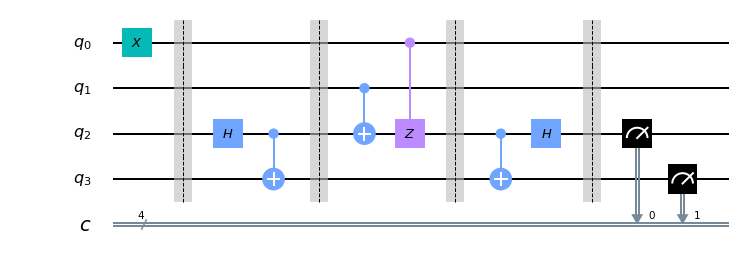

In [3]:
cs =[1, 0]

c = coding_circuit(cs)
c.draw(output='mpl')

## Explanation
Please have a look at above circuit as ordered segments between vertical barriers.
* First segment just sets state on q0 and q1 which corresponds to classical bits we want to encode. (So all superpositions are not allowed here, only 0s and 1s)
* Next segment corresponds to Bell state creation, "phi +" to be precise. **After this segment q3 is physically sent to 2nd person**
* Next segment is actual encoding phase. 1st person, depending on classical state perform operations on one of entagled qbits.  **After this segment q2 is also physically sent to 2nd person**
* In the last 2 segments firstly we apply reversed gates as in entagled state creation and then measure. **It is called measuremnt in Bell basis**


# Task 2 - Quantum teleporation
Teleport (so send "insantly") quantum state.

I will partially use my code from previous laboratory (with adjustments for this task)

In [4]:
def teleportation_circuit(state_to_teleport, deffer=False):
    # q[0] to be teleported
    state_to_teleport.barrier()
    state_to_teleport.h(1)
    state_to_teleport.cx(1, 2)
    state_to_teleport.barrier()
    state_to_teleport.cx(0, 1)
    state_to_teleport.h(0)
    state_to_teleport.barrier()
    if not deffer:
        state_to_teleport.measure(0, 0)
        state_to_teleport.measure(1, 1)
    state_to_teleport.barrier()
    state_to_teleport.cx(1, 2)
    state_to_teleport.cz(0, 2)
    state_to_teleport.barrier()
    if not deffer:
        state_to_teleport.measure(2, 2)
    return state_to_teleport

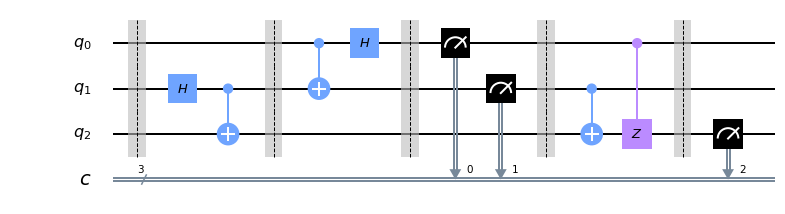

In [5]:
c = QuantumCircuit(3, 3)
c = teleportation_circuit(c)
c.draw(output='mpl')

## Explanation

Please have a look at above circuit as ordered segments between vertical barriers.
* All before first barier corresponds to setting up state on q0 which is going to be teleported
* Next segment - entagle q1 with q2. **Now physically send q2 to second person**
* Next perform CNOT and H on qbits in possesion of 1st person, so get one more entagled pair.
* Then measure q0 and q1. **Now send this measurement results to second person via conventional medium** (this part of process "slows down" whole teleportation :/ )
* In next segment, 2nd person apply gates X and Z conditionaly, based on received measurements
* In the last segment 2nd person measure q2 - which contains teleported state

# Experiments

In [6]:
backend = Aer.get_backend('statevector_simulator')

## Dense coding
For sake of simplicity i'm going to reimplement this with 2qbit state, so received result will be easier to interprete.

In [7]:
def coding_circuit(classical_state):
    c = QuantumCircuit(2, 2)
    c.barrier()
    c.h(0)
    c.cx(0, 1)
    c.barrier()
    if(classical_state[1] == 1):
        c.x(0)
    if(classical_state[0] == 1):
        c.z(0)
    c.barrier()
    c.cx(0, 1)
    c.h(0)
    c.barrier()
    c.measure(0, 0)
    c.measure(1, 1)
    return c

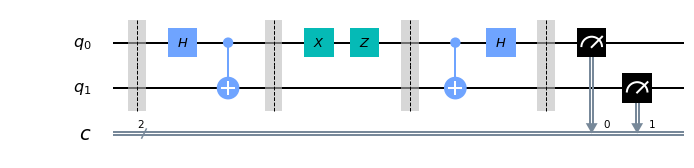

In [8]:
cs =[1, 1]

c = coding_circuit(cs)
c.draw(output='mpl')

In [9]:
def pretty_print(state_vec):
    keys = ['00', '10','01', '11']
    return { keys[i]: state_vec[i] for i in range(len(keys))}

In [10]:
for c0 in [0, 1]:
    for c1 in [0, 1]:
        cs = [c0, c1]
        c = coding_circuit(cs)
        job = execute(c, backend)
        result = job.result()
        outputstate = result.get_statevector(c, decimals=1)
        print('Cbits: {}{}, result:'.format(c0, c1), pretty_print(outputstate.real))

Cbits: 00, result: {'00': 1.0, '10': 0.0, '01': 0.0, '11': 0.0}
Cbits: 01, result: {'00': 0.0, '10': 0.0, '01': 1.0, '11': 0.0}
Cbits: 10, result: {'00': 0.0, '10': 1.0, '01': 0.0, '11': 0.0}
Cbits: 11, result: {'00': 0.0, '10': 0.0, '01': 0.0, '11': 1.0}


Probability of reading coded value always equals to 1.0

## Teleportation

I will construct some single qbit state, then teleport it and apply proper gates to revert it back to 0. Expectation is to measure 0 with 1.0 probability.


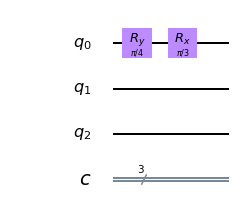

In [11]:
import numpy as np

def get_state_to_teleport():
    # prepare state on q0
    state_to_teleport = QuantumCircuit(3, 3)
    state_to_teleport.ry(np.pi/4, 0)
    state_to_teleport.rx(np.pi/3, 0)
    return state_to_teleport
    
get_state_to_teleport().draw(output='mpl')

Empirical proof that constructed state isn't trivial and it's easy to reverse

In [12]:
c = get_state_to_teleport()
job = execute(c, backend)
result = job.result()
outputstate = result.get_statevector(c, decimals=1)
print(outputstate)

c.rx(-np.pi/3, 0)
c.ry(-np.pi/4, 0)
job = execute(c, backend)
result = job.result()
outputstate = result.get_statevector(c, decimals=1)
print(outputstate)
# Only outputstate[0] should be != 0

[0.8+0.j  0.4-0.4j 0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j ]
[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


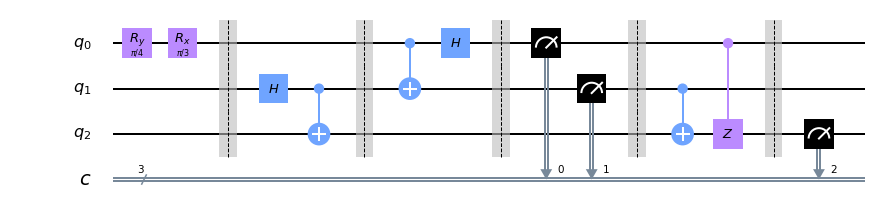

In [13]:
c = teleportation_circuit(get_state_to_teleport())
c.draw(output='mpl')

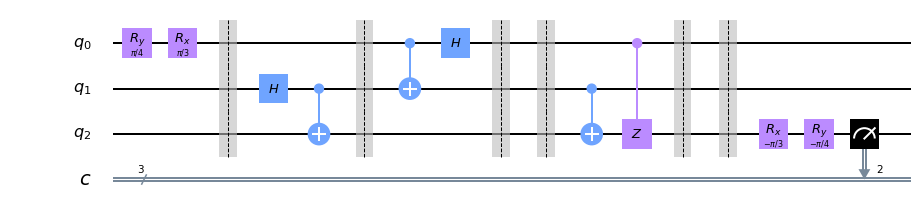

In [14]:
# Prepare teleportation
c = teleportation_circuit(get_state_to_teleport(), deffer=True)
# now teleported result is on q2, try to reverse it back to 0
c.rx(-np.pi/3, 2)
c.ry(-np.pi/4, 2)

c.measure(2, 2)
c.draw(output='mpl')



[0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]


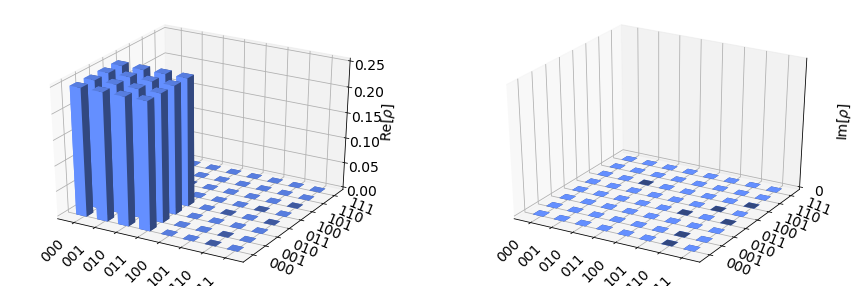

In [15]:
job = execute(c, backend)
result = job.result()
outputstate = result.get_statevector(c, decimals=1)
print(outputstate)
plot_state_city(outputstate)

Looking at density matrix we can easily say, that all options for q0 and q1 are possible, but it's always 0 on q2, which proves thesis state at the begining of the experiment.